# Step 1 get an image and extract Values from it:

# Init

In [1]:
# installs:
!pip install pyyaml==5.1
!pip install -q detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.8/index.html
!pip install -q datasets
!pip install -q pytesseract

In [12]:
# imports:
import torch
from transformers import LayoutLMv3Processor, AutoModelForTokenClassification
import numpy as np
from PIL import Image
import os
import pytesseract
import easyocr
from datasets.features import ClassLabel
from datasets import load_dataset
from typing import List
import re
import json

In [1]:
from datasets import load_dataset
# from huggingface_hub import notebook_login
# notebook_login()
dataset = load_dataset("Resi/layoutlmv3-full-annotation-filtered")
dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'tokens', 'bboxes', 'ner_tags', 'image_path', 'image'],
        num_rows: 439
    })
    test: Dataset({
        features: ['id', 'tokens', 'bboxes', 'ner_tags', 'image_path', 'image'],
        num_rows: 24
    })
})

In [2]:
import os
import torch
from transformers import LayoutLMv3Processor, AutoModelForTokenClassification

os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

processor = LayoutLMv3Processor.from_pretrained("microsoft/layoutlmv3-base")

model = AutoModelForTokenClassification.from_pretrained("Resi/layoutlmv3-multilabel-v2-colab")
model.to(device)

C:\Users\lukask\AppData\Local\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


LayoutLMv3ForTokenClassification(
  (layoutlmv3): LayoutLMv3Model(
    (embeddings): LayoutLMv3TextEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (x_position_embeddings): Embedding(1024, 128)
      (y_position_embeddings): Embedding(1024, 128)
      (h_position_embeddings): Embedding(1024, 128)
      (w_position_embeddings): Embedding(1024, 128)
    )
    (patch_embed): LayoutLMv3PatchEmbeddings(
      (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (norm): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
    (encoder): LayoutLMv3Encoder

In [3]:
from datasets.features import ClassLabel
def get_label_list(labels):
    unique_labels = set()
    for label in labels:
        unique_labels = unique_labels | set(label)
    label_list = list(unique_labels)
    label_list.sort()
    return label_list

features = dataset["train"].features
column_names = dataset["train"].column_names
image_column_name = "image"
text_column_name = "tokens"
boxes_column_name = "bboxes"
label_column_name = "ner_tags"

if isinstance(features[label_column_name].feature, ClassLabel):
    label_list = features[label_column_name].feature.names
    # No need to convert the labels since they are already ints.
    id2label = {k: v for k,v in enumerate(label_list)}
    label2id = {v: k for k,v in enumerate(label_list)}
else:
    label_list = get_label_list(dataset["train"][label_column_name])
    id2label = {k: v for k,v in enumerate(label_list)}
    label2id = {v: k for k,v in enumerate(label_list)}
    
num_labels = len(label_list)

# Function

In [4]:
def unnormalize_box(bbox, width, height):
     return [
         width * (bbox[0] / 1000),
         height * (bbox[1] / 1000),
         width * (bbox[2] / 1000),
         height * (bbox[3] / 1000),
     ]
def crop_boxes_with_margin(image, boxes, margin=4):
    cropped_images = []
    for box in boxes:
        x1, y1, x2, y2 = box
        x1 = max(0, x1 - margin)
        y1 = max(0, y1 - margin)
        x2 = min(image.width, x2 + margin)
        y2 = min(image.height, y2 + margin)
        cropped_image = image.crop((x1, y1, x2, y2))
        cropped_images.append(cropped_image)
    return cropped_images

def extract_text_from_image(image):
    return pytesseract.image_to_string(image)

def extract_text_from_image_easy_ocr(image):
    reader = easyocr.Reader(['en','de'])
    image_np = np.array(image)
    results = reader.readtext(image_np)
    full_text = ''
    for (bbox, text, prob) in results:
        full_text += text + " "  
    full_text = full_text.strip()
    return full_text
#     return " ".join(text for (_, text, _) in reader.readtext(image)).strip()
    

def adjust_and_ocr(image, bbox, x_extend=130, y_adjust=2):
    x1, y1, x2, y2 = bbox
    x2 += x_extend
    y1 -= y_adjust
    y2 += y_adjust
    cropped_adjusted_image = image.crop((x1, y1, x2, y2))
    #cropped_adjusted_image.show()
    return extract_text_from_image_easy_ocr(cropped_adjusted_image)

def has_keyword_followed_by_digit(extracted_texts, keywords):
    positions = []  # To hold positions of keywords
    # Convert list of keywords to lowercase once to improve efficiency
    keywords = [kw.lower() for kw in keywords]

    # Iterate through the extracted texts to find keywords
    for index, text in enumerate(extracted_texts):
        text_lower = text.lower()
        if any(kw in text_lower for kw in keywords):
            positions.append((index, text_lower))

    # Check for digits between the first and second keyword occurrences
    if len(positions) >= 2:
        # Extract the segment of texts between the first and second keyword
        segment = extracted_texts[positions[0][0] + 1:positions[1][0]]
        # Check if any text in the segment contains a digit
        for text in segment:
            if any(char.isdigit() for char in text):
                return True

    # Handle cases where only one keyword is found and then the list ends
    elif len(positions) == 1:
        # Check remaining texts after the first keyword for any digits
        segment = extracted_texts[positions[0][0] + 1:]
        for text in segment:
            if any(char.isdigit() for char in text):
                return True

    return False  # Return False if no suitable pattern is found

In [5]:
def mast_extraction(image, image_name):
    encoding = processor(image, return_offsets_mapping=True, return_tensors="pt")
    offset_mapping = encoding.pop('offset_mapping') 

#     for k, v in encoding.items():
#         encoding[k] = v.to(device)

    outputs = model(**encoding)
    predictions = outputs.logits.argmax(-1).squeeze().tolist()
    token_boxes = encoding.bbox.squeeze().tolist()
    width, height = image.size
    pred_boxes = [unnormalize_box(box, width, height) for box in token_boxes]
    pred_labels = [id2label[pred] for pred in predictions]
    
    #Do I need these?:
    # Filter out only the bounding boxes labeled "mast"
    mast_boxes = []
    # Filter out only the bounding boxes labeled "mast" and remove duplicates or similar boxes
    unique_mast_boxes = []
    seen = set()
    for box, label in zip(pred_boxes, pred_labels):
        if label == "B-Mast":
            box_tuple = tuple(box)
            if box_tuple not in seen:
                unique_mast_boxes.append(box)
                seen.add(box_tuple)
                
    # Cropping out the tokens that correspond with Mast and saving them in Mast to visualize
    cropped_images = crop_boxes_with_margin(image, unique_mast_boxes)
    for i, cropped_image in enumerate(cropped_images):
        directory_path = f".\data\mast_extract\{image_name}"
        if not os.path.exists(directory_path):
            os.makedirs(directory_path)
        file_path = os.path.join(directory_path, f"cropped_mast_{i + 1}.png")
        cropped_image.save(file_path)
    
    extracted_texts = [extract_text_from_image_easy_ocr(cropped_image) for cropped_image in cropped_images]
    # Sort out empty strings
    merged_sentence = ' '.join(extracted_texts)
    words = merged_sentence.split()
    #print("extracted_texts:", extracted_texts)
    
    mast_index = None
    mast_bbox = None
    
    #finds first occurence of Mast or Nr
    for i, text in enumerate(extracted_texts):
        if "mast" in text.lower() or "nr" in text.lower() or "m" in text.lower():
            mast_index = i
            mast_bbox = unique_mast_boxes[i]
            break
    #print(f"mast_index: {mast_index}")
    
    mast_occurences = ""
    
    if mast_index is not None:       
        while mast_index < len(extracted_texts):
            current_text = [w.strip() for w in extracted_texts[mast_index:]]
            #print(f"current_text: {current_text}")

            if not has_keyword_followed_by_digit(current_text, ["Mast", "Nr."]):
                counter = 0
                ocr_result = None
                mast_bbox = unique_mast_boxes[mast_index]
                #keine nummer zwischen den ersten beiden keywortern
                while counter < 1:    
                    ocr_result = adjust_and_ocr(image, mast_bbox)
                    
                    #print(f"counter: {counter}")
                    counter +=1
                    
                    # Break if a number is found after adjustment
                    if any(char.isdigit() for char in ocr_result):
                        #print("Broken out")
                        mast_occurences += ocr_result
                        break
            else:
                mast_occurences += ', ' + ' '.join(current_text)
                mast_index += 1
            mast_index += 1 
        print(f"mast_occurences: {mast_occurences}")
        return mast_occurences
              

In [ ]:
from PIL import Image
import easyocr
import numpy as np
import warnings
warnings.filterwarnings("ignore", message="Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.")
#2#12#13#17#18
# example = dataset["test"][13]
# image = example["image"]
image = Image.open(r"C:\Users\lukask\Coding\Interface Projects\Detection\Complete_Data\fichtner_dataset_v2\png_with_label_downscaled_1_1_ground_truth\319.png")
#image = Image.open(r"C:\Users\lukask\Coding\Interface Projects\Detection\LayoutLM\finetune_on_documents_try_3\data\segm_extract\cropped_segment_1.png")
t = mast_extraction(image, "image_127")
t

In [ ]:
image

# Splitting image to smaller tokens and extracting mast nr then

In [13]:
from typing import List
def split_image_horizontally(image: Image, max_tokens: int = 512) -> List[Image]:
    """
    Splits an image horizontally into smaller segments each with fewer than max_tokens tokens.
    
    Parameters:
        image (PIL.Image): The original image to be split.
        processor: The processor used for tokenizing.
        max_tokens (int): The maximum number of tokens for each image segment.
    
    Returns:
        List of Image objects, each representing a segment of the original image.
    """
    width, height = image.size
    segments = []
    current_height = 0

    # Continuously try to split until the entire height is covered
    while current_height < height:
        min_height = 100  # Minimum height increase to attempt finding a valid segment
        found = False
        last_valid_height = current_height + min_height  # Default to minimal segment in case of no valid split found

        for h in range(current_height + min_height, height + min_height, min_height):
            segment = image.crop((0, current_height, width, h))
            encoding = processor(segment, return_offsets_mapping=True, return_tensors="pt")
            num_tokens = encoding.input_ids.size(1)
            # print(f"Trying height {h}: {num_tokens} tokens")

            if num_tokens < max_tokens:
                last_valid_height = h
                found = True
            else:
                if found:
                    break  # Use the last valid height
                else:
                    # If even the smallest increment is too large, reduce min_height
                    min_height = max(50, min_height // 2)
                    break

        # Crop using the last valid height that had fewer than max_tokens
        segment = image.crop((0, current_height, width, last_valid_height))
        segments.append(segment)
        current_height = last_valid_height  # Move the current height to the end of the last valid segment

        if not found:
            # Adjust in case no valid segment is found to prevent infinite loop
            current_height += min_height

    return segments

In [ ]:
example = dataset["test"][3]
image = example["image"]
image = Image.open(r"C:\Users\lukask\Coding\Interface Projects\Detection\Complete_Data\fichtner_dataset_v2\png_with_label_downscaled_1_1_ground_truth\319.png")

segments = split_image_horizontally(image)
for i, seg_image in enumerate(segments):
    #print(f"Segment {i+1}:")
    seg_image.save(f".\data\segm_extract\cropped_segment_{i}.png")
    #seg_image.show()

In [ ]:
extracted_mast = ""
for i, seg_image in enumerate(segments):
    image_name = f"segment_{i}"
    extracted_mast += str(mast_extraction(seg_image,image_name))

In [ ]:
extracted_mast

In [14]:
def make_numbers_unique(text):
    # Use the regular expression to find patterns of digits possibly preceded or followed by letters
    pattern = r'[A-Za-z]*\d+[A-Za-z]*'

    # Find all matches using the regex pattern
    mast_numbers = re.findall(pattern, text)

    # Ensure that all captured matches are valid numbers possibly prefixed or suffixed by letters
    # and are not just single digits
    valid_mast_numbers = [num for num in mast_numbers if re.match(r'[A-Za-z]*\d+[A-Za-z]+|\d{2,}', num)]

    # Remove duplicates by converting the list to a set and then back to a list
    unique_mast_numbers = list(set(valid_mast_numbers))

    return unique_mast_numbers

# LayoutLMv3 Mast Inference

In [ ]:
dataset = load_dataset("Resi/dofi_v4", split="test")

In [15]:
import re

def extract_mast_numbers(text):
    """
    Extracts mast numbers from a given text.
    Mast numbers can appear with or without the prefix 'Mast', such as '256A', '008,211,218', '817A-Mast', or simply '560'.
    This function aims to capture all such numbers and normalize them for comparison.
    """
    # Regex pattern to capture numbers with optional 'Mast' prefix
    pattern = r"(?:Mast[-\s]*Nr\.?\s*|Mast\s+)?([\dA-Za-z,-]+)"
    matches = re.findall(pattern, text)
    normalized_numbers = set()

    for match in matches:
        # Normalize by removing spaces, splitting on commas, and ensuring consistent upper-case
        parts = re.split(r'[\s,]+', match)
        for part in parts:
            normalized_part = part.strip().upper().replace("-", "")
            if normalized_part:
                normalized_numbers.add(normalized_part)

    #print(f"Extracted and normalized mast numbers from '{text}': {normalized_numbers}")
    return normalized_numbers

def compare_mast_numbers(true_answer, mast_occurrence):
    """
    Compare mast numbers in true_answer with those in a single mast_occurrence to check for any overlap.
    """
    true_answer_nums = extract_mast_numbers(true_answer)
    occurrence_nums = extract_mast_numbers(mast_occurrence)
    
    print(f"True answer nums: {true_answer_nums}")
    print(f"Occurrence nums: {occurrence_nums}")

    return not true_answer_nums.isdisjoint(occurrence_nums)

# Example usage
true_answer = "Mast Nr. 256A"
mast_occurrence = "Mast Nr. 256A"

result = compare_mast_numbers(true_answer, mast_occurrence)
print("Do they share any mast numbers?", result)


True answer nums: {'256A'}
Occurrence nums: {'256A'}
Do they share any mast numbers? True


In [ ]:
import json
true = 0
false = 0
num = 21
for image_name, image, ground_truth_str in zip(dataset['image_id'], dataset['image'], dataset['ground_truth']):
    ground_truth = json.loads(ground_truth_str)
    question = ground_truth["gt_parses"][0]["question"]
    true_answer = ground_truth["gt_parses"][0]["answer"]
    if question == "Mast":
        print(f"image_name: {image_name}")
        #Layoutlm answer:
        segments = split_image_horizontally(image)

        extracted_mast = ""

        for i, seg_image in enumerate(segments):
            extracted_mast += str(mast_extraction(seg_image, image_name))
        #mast_list = make_numbers_unique(extracted_mast)
        if compare_mast_numbers(true_answer, extracted_mast):
            true+=1
        else:
            false+=1
print(true, false)
    

# Easy Ocr Test:

In [ ]:
cropped_image = r"C:\Users\lukask\Coding\Interface Projects\Detection\LayoutLM\finetune_on_documents_try_3\data\mast_extract\cropped_mast_1.png"
text = extract_text_from_image_easy_ocr(cropped_image)
print(text)

In [ ]:
1-4/17

# Connect Donut with LayoutLM

In [16]:
import pandas as pd
import re

file_path = r'C:\Users\lukask\Coding\Interface Projects\Detection\Complete_Data\Azure_Label\EPLASS Plannummernkonvention_20231016.xlsx'

# Load the Excel file, skipping the first 14 rows
data = pd.read_excel(file_path, skiprows=14)
def extract_parentheses(text):
    # Find text within the first set of parentheses
    result = re.search(r'\((.*?)\)', text)
    return result.group(1) if result else text

new_columns = [
    "Projektkürzel_bezeichner", "Projektkürzel", "Leitungsanlage_bezeichner", "Leitungsanlage",
    "Mast_bezeichner", "Mast", "Erstellerschlüssel_bezeichner", "Erstellerschlüssel",
    "Dokumentenart_bezeichner", "Dokumentenart", "Dokumenttyp_bezeichner", "Dokumenttyp",
    "lfd. Nummer", "Index"
]
current_columns = data.columns

column_rename_map = dict(zip(current_columns, new_columns))

data.rename(columns=column_rename_map, inplace=True)

pd.set_option('display.max_rows', None)  # Adjust based on your preference
pd.set_option('display.max_columns', None)  # Adjust to display all columns
pd.set_option('display.width', 1000)  # Adjust the width to fit your screen
pd.set_option('display.colheader_justify', 'center')  # Center the column headers
pd.set_option('display.precision', 3)  # Set the precision of floating point numbers

data.columns = [extract_parentheses(col) for col in data.columns]
#display(data)

def format_with_leading_zeros(number, desired_length):
    # Convert the number to an integer if it's a float without a decimal part,
    # otherwise, leave it as is (it will be converted to a string next).
    if isinstance(number, float) and number.is_integer():
        number = int(number)

    # Convert the number to a string
    number_str = str(number)

    # Pad with leading zeros
    return number_str.zfill(desired_length)

# Apply the formatting to the specific columns
data['Erstellerschlüssel_bezeichner'] = data['Erstellerschlüssel_bezeichner'].apply(lambda x: format_with_leading_zeros(x, 2))
data['Dokumenttyp_bezeichner'] = data['Dokumenttyp_bezeichner'].apply(lambda x: format_with_leading_zeros(x, 3))
data['Leitungsanlage_bezeichner'] = data['Leitungsanlage_bezeichner'].apply(lambda x: format_with_leading_zeros(x, 4))

# for column in columns_to_format:
#     data[column] = data[column].apply(format_with_leading_zero)

def get_pure_dataset(answer):
    if pd.isna(answer):
        return answer  # Return NaN as is to avoid type errors
    
    answer = str(answer)
    # Define replacements for German umlauts and ss
    replacements = {
        'ö': 'o',
        'Ö': 'O',
        'ä': 'a',
        'Ä': 'A',
        'ü': 'u',
        'Ü': 'U',
        'ß': 'ss'
    }

    # Replace each German character with its replacement
    for german_char, replacement in replacements.items():
        answer = answer.replace(german_char, replacement)
    
    # Remove specific substrings
    answer = answer.replace("Deutschland", "")
    answer = answer.replace("deutschland", "")
    answer = answer.replace("GmbH", "")
    answer = answer.replace("gmbh", "")

    # Optionally, remove spaces and convert to lower case
    answer = re.sub(r'\s+', '', answer)  # Remove all kinds of whitespace
    answer = answer.lower()  # Convert to lower case for uniformity

    return answer

data = data.applymap(get_pure_dataset)
display(data.head())


,Projektkürzel_bezeichner,Projektkürzel,Leitungsanlage_bezeichner,Leitungsanlage,Mast_bezeichner,Mast,Erstellerschlüssel_bezeichner,Erstellerschlüssel,Dokumentenart_bezeichner,Dokumentenart,Dokumenttyp_bezeichner,Dokumenttyp,lfd. Nummer,Index
0,nbr,netzverstarkungbadischerheinschiene,0000,ubergeordnet,00000,keinemastanlage,00,transnetbw,sp,schemaplane,005,leiter-undphasenfuhrungsplan(ihl),00001,00
1,000,bestandsdokumentation,0438,bahnstromleitungappenweier-karlsruhe,217aa,mast217aa,01,eqosenergie,NaN,NaN,006,phasenfuhrungsplanist/soll,00002,01
2,NaN,NaN,1450,daxlanden-weier,219aa,mast219aa,02,bouyguese&senertranssa,NaN,NaN,008,seilverlege-undverbinderplan,00003,02
3,NaN,NaN,1470,anschlussbuhl,725,mast725,03,spiesag,NaN,NaN,009,"phasenlage,seilverlaufu.stromkreisbenennung",00004,03
4,NaN,NaN,4568,maximiliansau-daxlanden,725a,mast725a,04,europeantransenergy,NaN,NaN,010,stromkreislangenquerschnittsplanist/soll,usw.,usw.


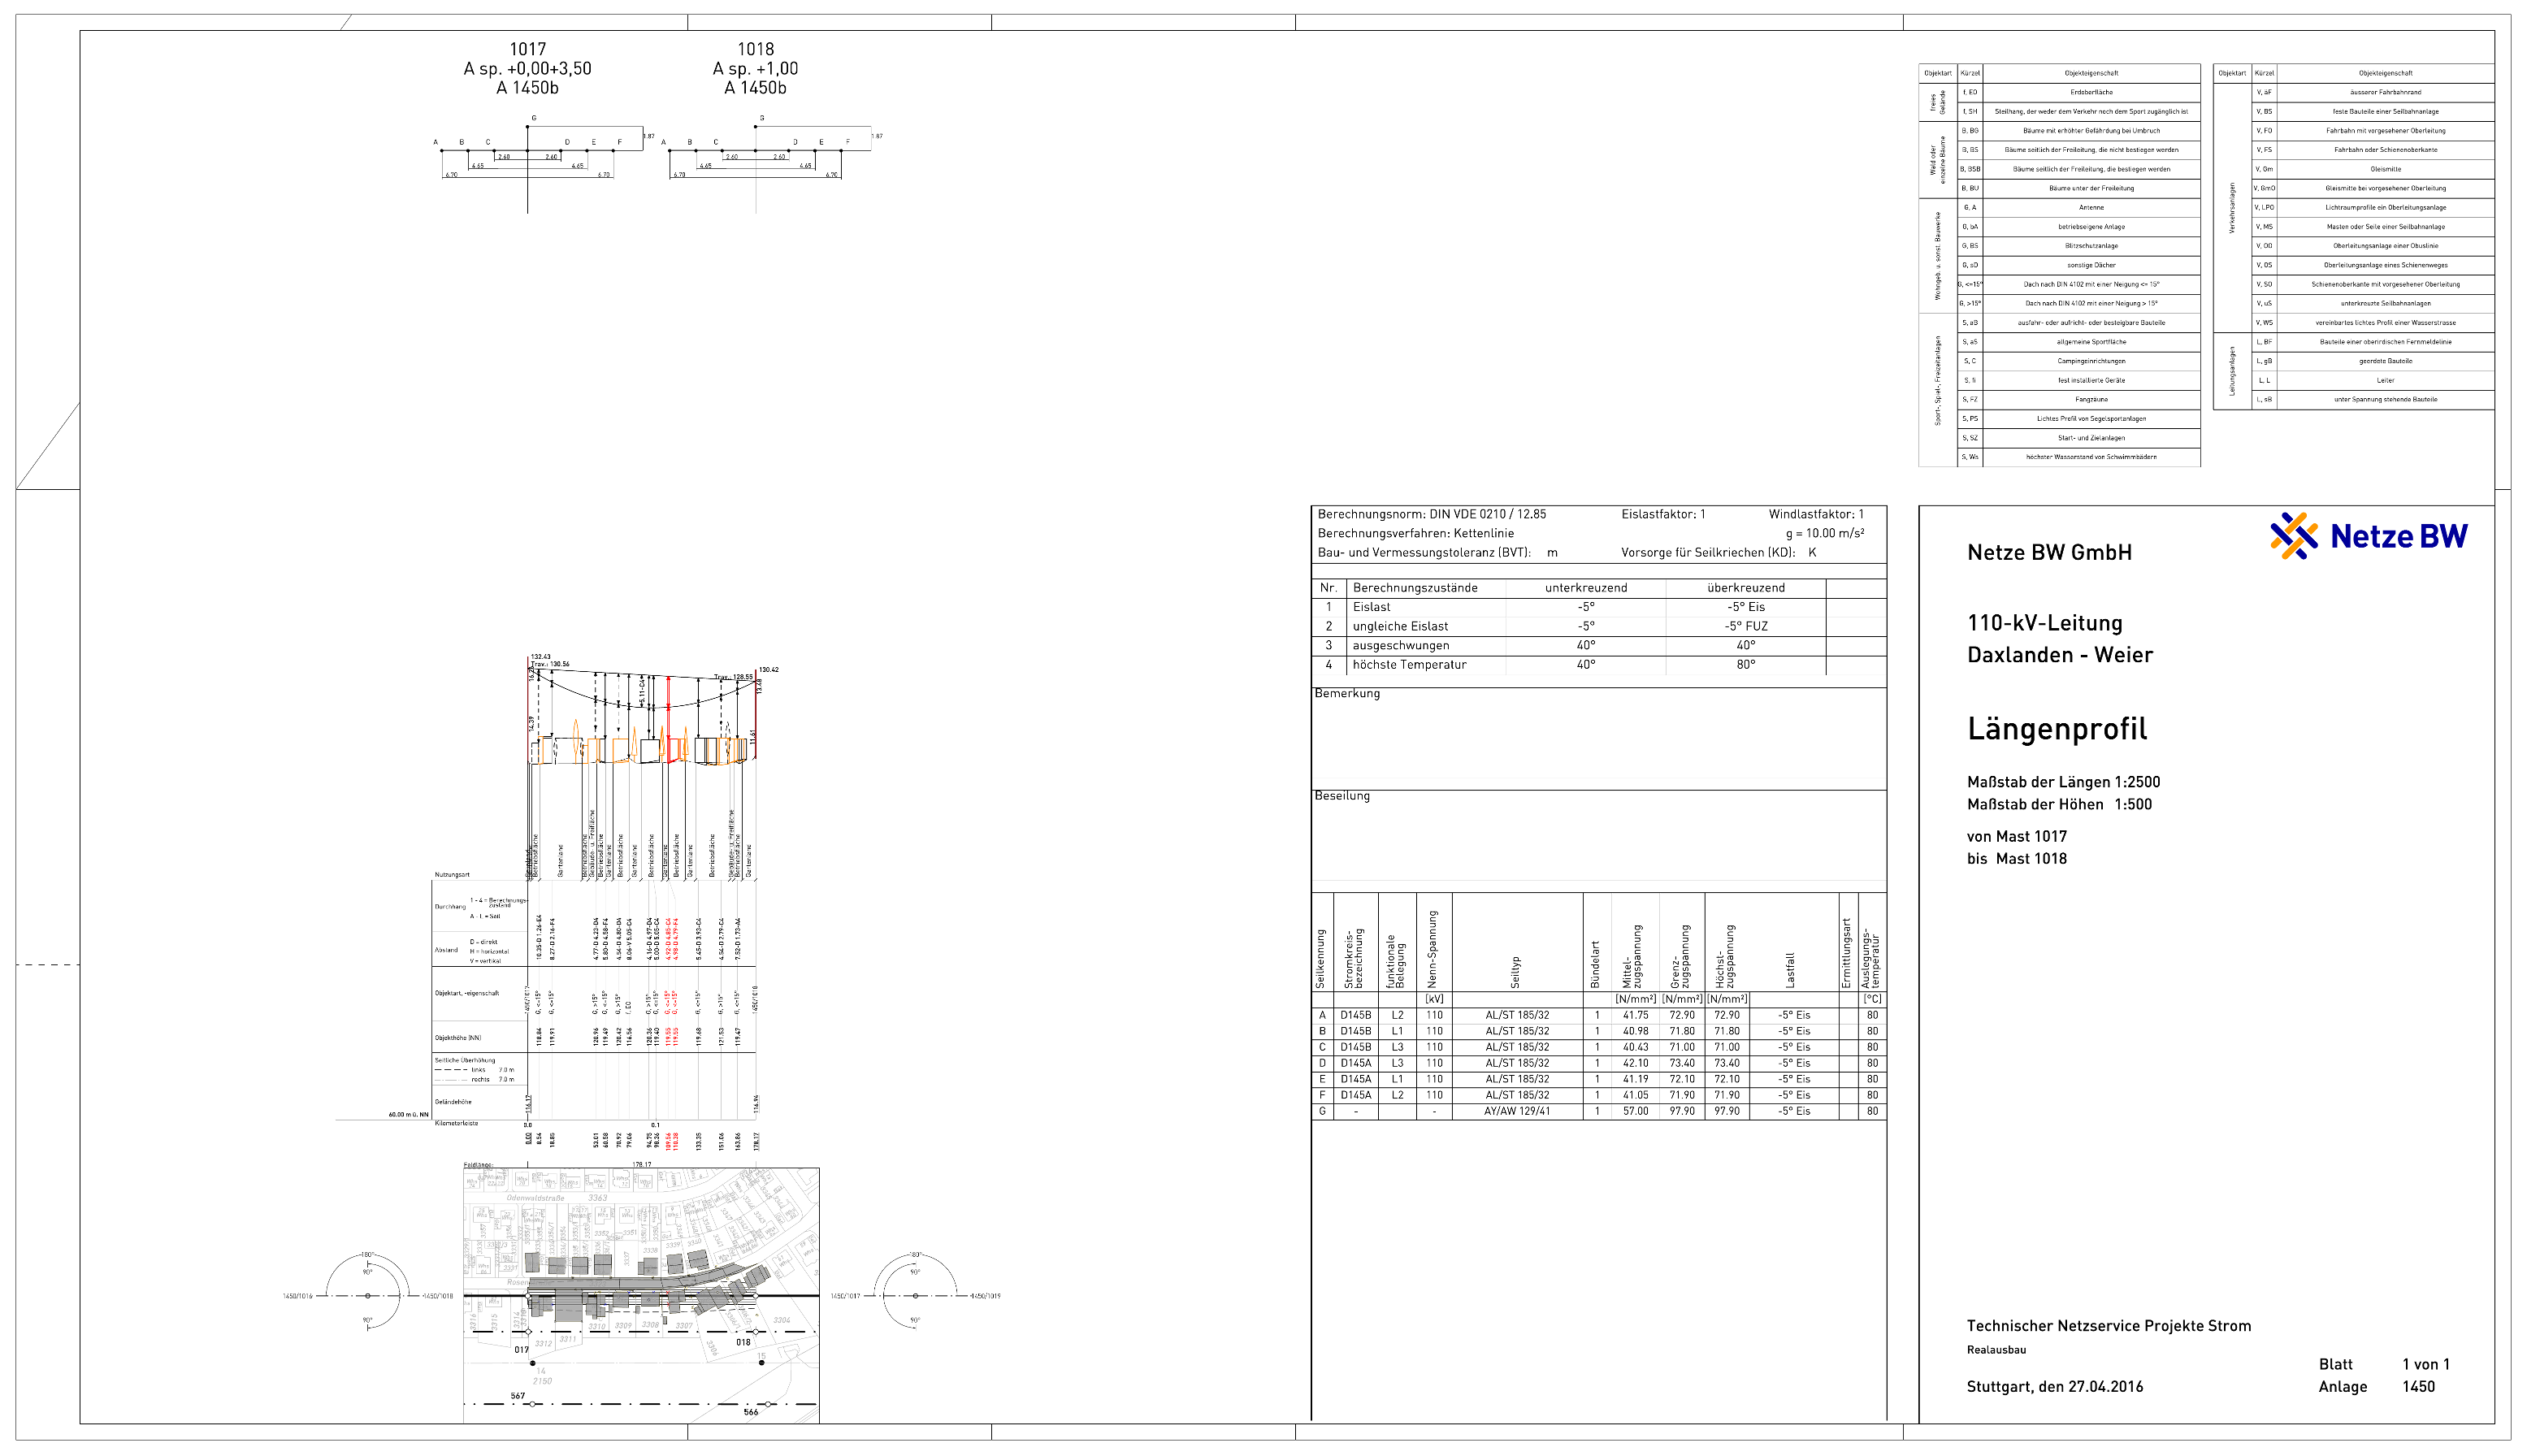

In [23]:
from PIL import Image
image = Image.open(r"C:\Users\lukask\Coding\Interface Projects\Detection\Complete_Data\fichtner_dataset_v2\png_with_label_downscaled_1_1_ground_truth\319.png")
image = Image.open(r'C:\Users\lukask\Coding\Interface Projects\Detection\Complete_Data\fichtner_dataset_v2\png_with_label_downscaled_1_1_ground_truth\447.png')
image = Image.open(r'C:\Users\lukask\Coding\Interface Projects\Detection\Complete_Data\fichtner_dataset_v2\png_with_label_downscaled_1_1_ground_truth\186953-413_D1_Index_03.png')
image = dataset['train'][13]['image'] #10 #13 #14

image

In [24]:
%%time
from transformers import DonutProcessor, VisionEncoderDecoderModel

def get_pure_answer(question:str, answer: str):
    answer = str(answer)
    while question in answer:
        answer = answer.replace(question, '')
    answer = re.sub(r'[,.\/\-=:;_ ]', '', answer)
    answer = answer.lower()
    answer = answer.replace("gmbh", "")
    answer = answer.replace("deutschland", "")
    answer = answer.replace("nr", "")# rausnehmen?
    
    replacements = {
        'ö': 'o',
        'ä': 'a',
        'ü': 'u',
        'ū': 'u',
        'ß': 'ss',
        'massstm': 'massst',
        
        'odos': 'eqos'
    }
    
    # Replace each German character with its replacement
    for german_char, replacement in replacements.items():
        answer = answer.replace(german_char, replacement)
    
    return answer

donut_processor = DonutProcessor.from_pretrained("Resi/donut-docvqa-sagemaker")
donut_model = VisionEncoderDecoderModel.from_pretrained("Resi/donut-docvqa-sagemaker")
output_dict = {}

# Your existing code
prompts = ["Leitungsanlage", "Mast", "Ersteller", "Dokumenttyp", "Massstab"]
pixel_values = donut_processor(image, return_tensors="pt").pixel_values
for prompt in prompts:
    decoder_input_ids = donut_processor.tokenizer(prompt, add_special_tokens=False, return_tensors="pt")["input_ids"]

    outputs = donut_model.generate(pixel_values,
                             decoder_input_ids=decoder_input_ids,
                             max_length=donut_model.decoder.config.max_position_embeddings,
                             early_stopping=False,
                             pad_token_id=donut_processor.tokenizer.pad_token_id,
                             eos_token_id=donut_processor.tokenizer.eos_token_id,
                             use_cache=True,
                             num_beams=1,
                             bad_words_ids=[[donut_processor.tokenizer.unk_token_id]],
                             return_dict_in_generate=True,
                             output_scores=True)
    seq = donut_processor.batch_decode(outputs.sequences)[0]
    seq = seq.replace(donut_processor.tokenizer.eos_token, "").replace(donut_processor.tokenizer.pad_token, "")
    seq = re.sub(r"<.*?>", "", seq, count=1).strip()  # remove first task start token
    
    scores = outputs.scores  # List of tensors with log probabilities
    probs = [torch.softmax(score, dim=-1) for score in scores]  # Convert to probabilities
    max_probs = [torch.max(prob, dim=-1)[0] for prob in probs]  # Get max probability for each step
    confidence_values = [prob.item() for prob in max_probs]  # Convert to list of floats
    average_confidence = np.mean(confidence_values)

    # Store the results in the dictionary
    output_dict[prompt] = {'sequence': get_pure_answer(prompt,seq), 'average_confidence': average_confidence}
    print(prompt, get_pure_answer(prompt,seq), average_confidence)

C:\Users\lukask\AppData\Local\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Leitungsanlage daxlandenweier 0.9999997019767761
Mast 1016 0.9634474317232767
Ersteller netzebw 0.9976409435272217
Dokumenttyp langenprofil 1.0
Massstab massstabderlangen12500 0.9999858140945435
CPU times: total: 2min 10s
Wall time: 56.7 s


In [25]:
# Donut:
import pandas as pd
from fuzzywuzzy import process, fuzz
import warnings
import logging

confidence_thresholds = {
    'Dokumenttyp': 99.1,
    'Mast': 80.0, #97.0,
    'Leitungsanlage': 97.0,
    'Ersteller': 98.16
}

column_mapping = {
    'Leitungsanlage': 'Leitungsanlage',
    'Mast': 'Mast',
    'Ersteller': 'Erstellerschlüssel',
    'Dokumenttyp': 'Dokumenttyp'
}


for key, value in output_dict.items():
    if key == 'Massstab':  # Skip processing for 'massstab'
        continue
        
    threshold = confidence_thresholds.get(key, 100.0) / 100.0
    
    if value['average_confidence'] > threshold:
        if key in column_mapping:
            column_name = column_mapping[key]
            if column_name in data.columns and column_name != 'Dokumenttyp' and column_name != 'Mast':
                # Create a cleansed version of the column for matching
                cleansed_column = data[column_name].apply(lambda x: get_pure_answer(key, x))
                result = process.extractOne(value['sequence'], cleansed_column)
                if result:
                    best_match, match_score = result[0], result[1]  # Safely unpack only the first two elements
                    print(f"Nearest word for {column_name} based on {value['sequence']}: {best_match} with score {match_score}")
                else:
                    print(f"No suitable match found for {value['sequence']} in column {column_name}")
                    
            elif column_name == 'Dokumenttyp':
                cleansed_column = data[column_name].apply(lambda x: get_pure_answer(key, x)) # returns the column with all the values in it changed to pure form
                result = process.extractOne(value['sequence'], cleansed_column) # extracts the most similar one
                
                data[column_name] = data[column_name].fillna('') #fills or NaN with ''
                if result:
                    best_match, match_score = result[0], result[1]  # Safely unpack only the first two elements
                    print(f"Nearest word for {column_name} based on {value['sequence']}: {best_match} with score {match_score}")
                print("But could be: ")
                pattern = f"{value['sequence']}"  # \b denotes word boundaries
                matches = data[cleansed_column.str.contains(pattern, regex=True, case=False)]
                if not matches.empty:
                    for match in matches[column_name]:
                        print(f"Word in {column_name}: {match}")
            elif column_name == 'Mast':
                cleansed_column = data[column_name].apply(lambda x: get_pure_answer(key, x))
                result = process.extractOne(value['sequence'], cleansed_column)
                if result:
                    best_match, match_score = result[0], result[1]  # Safely unpack only the first two elements
                    print(f"Nearest word for {column_name} based on {value['sequence']}: {best_match} with score {match_score}")
                else:
                    print(f"No suitable match found for {value['sequence']} in column {column_name}")
                print("LayoutLM output: ")
                warning_state = warnings.filters[:]
                logging_state = logging.getLogger().level
                warnings.filterwarnings("ignore")
                logging.getLogger().setLevel(logging.ERROR)
                
                segments = split_image_horizontally(image)
                extracted_mast = ""
                for i, seg_image in enumerate(segments):
                    image_name = f"donut_extraction_{i}"
                    extracted_mast += str(mast_extraction(seg_image, image_name))
                print(extracted_mast)
                
                warnings.filters = warning_state
                logging.getLogger().setLevel(logging_state)
                
            else:
                print(f"Column {column_name} not found in DataFrame.")
        else:
            print(f"No column mapping found for key: {key}")
    else:
        print(f"Not confident for {key}: confidence {value['average_confidence']}")

Nearest word for Leitungsanlage based on daxlandenweier: daxlandenweier with score 100
Nearest word for Mast based on 1016: mast116 with score 77
LayoutLM output: 
mast_occurences: , Mast 1017 Mast 1018, Mast 1018
, Mast 1017 Mast 1018, Mast 1018None
Nearest word for Erstellerschlüssel based on netzebw: netzebw with score 100
Nearest word for Dokumenttyp based on langenprofil: langenprofilvollausbauplanung(ihl) with score 90
But could be: 
Word in Dokumenttyp: langenprofilvollausbauplanung(ihl)
Word in Dokumenttyp: langenprofilvollausbauplanung
Word in Dokumenttyp: langenprofilrealisierungsstand(ihl)
Word in Dokumenttyp: langenprofilrealisierungsstand
